In [62]:
import pandas as pd
import numpy as np
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
from sklearn.preprocessing import StandardScaler

In [63]:
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()

# Load data

In [64]:
tag = pd.read_excel('./data/tag盤點表20200323.xlsx')
print(tag.shape)
tag

(94, 10)


,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
0,1.0,MLPAP_TJC-0627.PV,OX預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,140,160,***
1,2.0,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,160,200,***
2,3.0,MLPAP_FR-0632.PV,汽機風量,流量,KNM3/HR,可控制因子,1分鐘2筆,30,90,****
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
4,5.0,MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****
...,...,...,...,...,...,...,...,...,...,...
89,90.0,MLPAP_PI-0771.PV,E220出口壓力,壓力,mbar,不可控制因子,1分鐘2筆,0,200,***
90,91.0,MLPAP_TRC-0747.PV,E220出口溫度,溫度,℃,可控制因子,1分鐘2筆,100,200,***
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,第二模型使用,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
tag[tag['TAG']=='MLPAP_TJC-0757.PV']

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)


In [66]:
df = pd.read_csv('./data/train(tag_sheet_check).csv',index_col=0,parse_dates=True)
print(df.shape)
df.head()

(193824, 93)


,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V125-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV
2016-05-09 00:00:00,400.0,401.957120,400.751866,402.250788,401.148767,401.0,400.050078,403.0,402.0,401.0,...,0.0,0.000005,4.045683,6.484770,NaN,-1.000000,1.635186,0.051,-1.38272,133.100006
2016-05-09 00:10:00,400.0,401.942713,400.949883,402.249145,401.000000,401.0,400.249800,403.0,402.0,401.0,...,0.0,0.000010,4.152250,6.449888,NaN,-1.000000,1.625011,0.051,-1.38273,133.100006
2016-05-09 00:20:00,400.0,401.900145,400.899767,402.101255,401.000000,401.0,400.100155,403.0,402.0,401.0,...,0.0,0.000014,4.202449,6.440502,NaN,-0.898558,1.649780,0.051,-1.40000,133.100006
2016-05-09 00:30:00,400.0,401.949936,400.900210,402.300333,401.000000,401.0,400.144695,403.0,402.0,401.0,...,0.0,0.000019,4.146723,6.463649,NaN,-0.509010,1.635187,0.051,-1.40000,133.199997
2016-05-09 00:40:00,400.0,402.000000,400.850037,402.176070,401.000000,401.0,400.405002,403.0,402.0,401.0,...,0.0,0.000024,4.011298,6.414799,NaN,-0.992771,1.654259,0.051,-1.30000,133.100006


# handle error

In [67]:
df.columns = [str(i).replace('TI','TJ') for i in df.columns]
tag['TAG'] = [str(i).replace('TI','TJ') for i in tag['TAG'].values]

In [68]:
temp = tag[tag['TAG']=='MLPAP_TJC-0757A.PV'].copy()
temp['TAG'] = 'MLPAP_TJ-0757B.PV'
tag = tag.append(temp)

In [69]:
print('only in df:')
set(df.columns) - set(tag['TAG'])

print('only in tag:')
set(tag['TAG']) - set(df.columns)

only in df:
only in tag:


{'nan', '第二模型使用'}

# spec clip or to np.nan

In [70]:
for i in tqdm(df.columns):
    if i == 'DATA OF USE':
        continue
    lb = tag[tag['TAG']==i]['min'].values[0]
    ub = tag[tag['TAG']==i]['max'].values[0]
    out = (df[i]<lb)|(df[i]>ub)
    # clip or to np.nan
    #df[i] = np.clip(df[i].values,lb,ub)
    df.loc[out,i] = np.nan
df.head()

,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V125-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV
2016-05-09 00:00:00,400.0,401.957120,400.751866,402.250788,401.148767,401.0,400.050078,403.0,402.0,401.0,...,NaN,0.000005,4.045683,NaN,NaN,NaN,1.635186,0.051,NaN,133.100006
2016-05-09 00:10:00,400.0,401.942713,400.949883,402.249145,401.000000,401.0,400.249800,403.0,402.0,401.0,...,NaN,0.000010,4.152250,NaN,NaN,NaN,1.625011,0.051,NaN,133.100006
2016-05-09 00:20:00,400.0,401.900145,400.899767,402.101255,401.000000,401.0,400.100155,403.0,402.0,401.0,...,NaN,0.000014,4.202449,NaN,NaN,NaN,1.649780,0.051,NaN,133.100006
2016-05-09 00:30:00,400.0,401.949936,400.900210,402.300333,401.000000,401.0,400.144695,403.0,402.0,401.0,...,NaN,0.000019,4.146723,NaN,NaN,NaN,1.635187,0.051,NaN,133.199997
2016-05-09 00:40:00,400.0,402.000000,400.850037,402.176070,401.000000,401.0,400.405002,403.0,402.0,401.0,...,NaN,0.000024,4.011298,NaN,NaN,NaN,1.654259,0.051,NaN,133.100006


# define columns

In [71]:
control_factor = tag[tag['category']=='可控制因子']['TAG'].values.tolist()
INPUT = get_col(df,'0619')
OUTPUT = get_col(df,'0997')
control_factor = list(set(control_factor) - set(INPUT) - set(OUTPUT))
control_factor = sorted(control_factor)
control_factor

['MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0741.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

In [72]:
df = df[INPUT+control_factor+OUTPUT]
df.head()

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0741.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV,MLPAP_FQI-0997.PV
2016-05-09 00:00:00,NaN,NaN,NaN,NaN,NaN,46.900002,NaN,NaN,1.635186,NaN,63.684562,NaN,133.100006,NaN,182.195587,NaN
2016-05-09 00:10:00,NaN,NaN,NaN,NaN,NaN,46.900002,NaN,NaN,1.625011,NaN,61.767096,NaN,133.100006,NaN,182.143029,NaN
2016-05-09 00:20:00,NaN,NaN,NaN,NaN,NaN,46.930040,NaN,NaN,1.649780,NaN,62.294110,NaN,133.100006,NaN,178.698310,NaN
2016-05-09 00:30:00,NaN,NaN,NaN,NaN,NaN,46.900002,NaN,NaN,1.635187,NaN,61.901655,NaN,133.199997,NaN,179.147420,NaN
2016-05-09 00:40:00,NaN,NaN,NaN,NaN,NaN,46.900002,NaN,NaN,1.654259,NaN,61.953602,NaN,133.100006,NaN,183.341350,NaN


# miss value

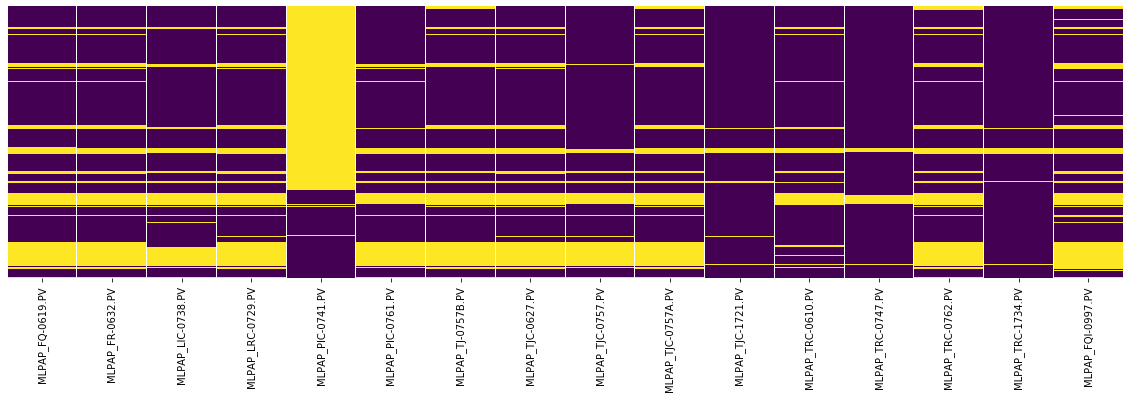

In [73]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# dropna(columns wise)

In [74]:
df = df.dropna(axis=1,thresh=len(df)*0.6)

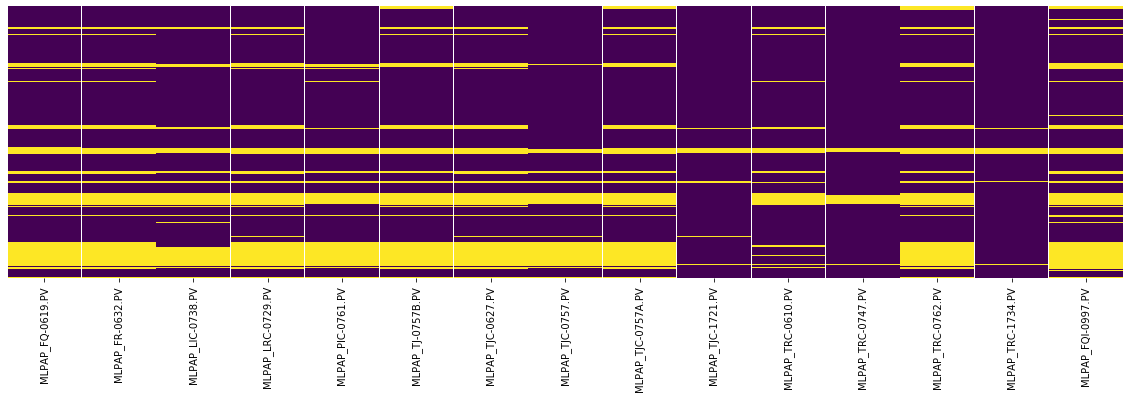

In [75]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# dropna(row wise)

In [76]:
#df = df.dropna(axis=0)

In [77]:
#fig = plt.figure(figsize=(20,5))
#sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [78]:
control_factor = list(set(df.columns)&set(control_factor))
control_factor = sorted(control_factor)
control_factor

['MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

# 0619 with 0997 trace plot

In [79]:
import plotly.graph_objects as go
import warnings 
warnings.simplefilter('ignore')

#d = df.head(100000)
#d['Date'] = d.index

#fig = go.Figure()

#fig.add_trace(go.Scatter(x=d.Date, y=d[OUTPUT[0]], name=OUTPUT[0]))
#fig.add_trace(go.Scatter(x=d.Date, y=d[INPUT[0]], name=INPUT[0]))

#fig.update_layout(title_text='Time Series with Rangeslider',xaxis_rangeslider_visible=True)
#fig.show()

# control_factor dist plot

In [80]:
#for i in control_factor:
#    sns.distplot(df.dropna().sample(1000)[i])
#    plt.show()

# stack time_step

In [81]:
x_col = INPUT + control_factor
y_col = OUTPUT

def train_windows(df, ref_day):
    X_train, Y_train, idx_lst = [], [], []
    for i in tqdm(range(len(df)-ref_day)):
        # 起始日 結束日
        start,end = i,i+ref_day
        # 確定該筆instance涵蓋的時間範圍內是否正常
        c = df.iloc[start:end+1].isnull().sum().sum()
        # 如果正常才製作成X,y pair
        if c == 0:
            X_train.append(df.iloc[start:end+1][x_col].values)
            Y_train.append(df.iloc[end][y_col].values[0])
            idx_lst.append(df.iloc[[end]].index[0])
        # 如果不正常就跳過
        else:
            pass
    # 重整資料 將二維X做flat 將y變Series
    X_train = np.array(X_train)
    flat_size = X_train.shape[1]*X_train.shape[2]
    X_train = X_train.reshape(-1,flat_size)
    Y_train = pd.Series(Y_train,index=idx_lst,name='Y')
    return X_train, Y_train, idx_lst

In [82]:
import time
s = time.time()
X,Y,idx_lst = train_windows(df,38)
Y = Y.values.reshape(-1,1)
print(time.time()-s)
print(X.shape)
print(Y.shape)


875.2077341079712
(134869, 546)
(134869, 1)


# save X,y

In [83]:
dataset = {}
dataset['X'] = X
dataset['Y'] = Y
dataset['idx'] = idx_lst
joblib.dump(dataset,'./data/dataset')
print('save done')

save done


# Load X,y

In [84]:
dataset = joblib.load('./data/dataset')
X = dataset['X']
Y = dataset['Y']
idx_lst = dataset['idx']
print('load done')

load done


# split train test

In [85]:
sp1 = int(len(X)*0.7)
sp2 = int(len(X)*0.85)
X_train,X_valid,X_test = X[:sp1],X[sp1:sp2],X[sp2:]
Y_train,Y_valid,Y_test = Y[:sp1],Y[sp1:sp2],Y[sp2:]
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(94408, 546)
(94408, 1)
(20230, 546)
(20230, 1)
(20231, 546)
(20231, 1)


# MinMaxScaler

In [86]:
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler().fit(X_train)
mm_y = MinMaxScaler().fit(Y_train)

In [87]:
joblib.dump(mm_x,'./model/mm_x.pkl')
joblib.dump(mm_y,'./model/mm_y.pkl')
print('save done!')

save done!


In [88]:
X_train = mm_x.transform(X_train)
X_valid = mm_x.transform(X_valid)
X_test = mm_x.transform(X_test)

Y_train = mm_y.transform(Y_train)
Y_valid = mm_y.transform(Y_valid)
Y_test = mm_y.transform(Y_test)

# torch tensor

In [89]:
import torch

X_train = torch.tensor(X_train).cuda()
X_test = torch.tensor(X_test).cuda()

X_valid = torch.tensor(X_valid).cuda()
Y_valid = torch.tensor(Y_valid).cuda()

Y_train = torch.tensor(Y_train).cuda()
Y_test = torch.tensor(Y_test).cuda()

# data_iter

In [90]:
train = torch.utils.data.TensorDataset(X_train, Y_train)
valid = torch.utils.data.TensorDataset(X_valid, Y_valid)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=True)

# Construct the neural network

In [91]:
class Net(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(Net,self).__init__()
        # fc_net
        self.fc = nn.Sequential(
            nn.Linear(input_shape,256),nn.ReLU(),
            nn.Linear(256,128),nn.ReLU(),
            nn.Linear(128,output_shape),
            nn.Sigmoid())

    def forward(self, x):
        return self.fc(x)

In [92]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [93]:
net = Net(X_train.shape[1],Y_train.shape[1]).cuda().double()
net.apply(init_weights)

Net(
  (fc): Sequential(
    (0): Linear(in_features=546, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# tensorboard

In [94]:
#with SummaryWriter(comment='Net')as w:
#    w.add_graph(net, (X_test,))

# torchviz

In [95]:
#torchviz.make_dot(net(X_test).mean(),params=dict(net.named_parameters()))

# loss_function and optimizer

In [96]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
loss_function = nn.MSELoss()

# Training and evaluation

In [97]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = 1000
    for epoch in range(num_epochs):
        
        # train model
        net.train()
        train_loss,i = 0,0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            i += 1
        
        # eval model
        net.eval()
        val_loss,j = 0,0
        for x, y in valid_iter:
            loss = loss_function(net(x),y)
            val_loss += loss.item()
            j += 1
        
        # before end epoch
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            joblib.dump(net,'./model/net.pkl')
            print('model saved')
        
        # record history
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    # return best trained net
    return net

model saved
epochs 0 train_avg_loss 0.0024 valid_avg_loss 0.0024
epochs 1 train_avg_loss 0.0009 valid_avg_loss 0.0034
epochs 2 train_avg_loss 0.0009 valid_avg_loss 0.0050
epochs 3 train_avg_loss 0.0009 valid_avg_loss 0.0059
epochs 4 train_avg_loss 0.0009 valid_avg_loss 0.0073
epochs 5 train_avg_loss 0.0009 valid_avg_loss 0.0076
epochs 6 train_avg_loss 0.0009 valid_avg_loss 0.0075
epochs 7 train_avg_loss 0.0009 valid_avg_loss 0.0087
epochs 8 train_avg_loss 0.0009 valid_avg_loss 0.0077
epochs 9 train_avg_loss 0.0008 valid_avg_loss 0.0102
epochs 10 train_avg_loss 0.0008 valid_avg_loss 0.0080
epochs 11 train_avg_loss 0.0008 valid_avg_loss 0.0103
epochs 12 train_avg_loss 0.0008 valid_avg_loss 0.0096
epochs 13 train_avg_loss 0.0008 valid_avg_loss 0.0095
epochs 14 train_avg_loss 0.0008 valid_avg_loss 0.0109
epochs 15 train_avg_loss 0.0008 valid_avg_loss 0.0112
epochs 16 train_avg_loss 0.0008 valid_avg_loss 0.0099
epochs 17 train_avg_loss 0.0008 valid_avg_loss 0.0114
epochs 18 train_avg_loss 0

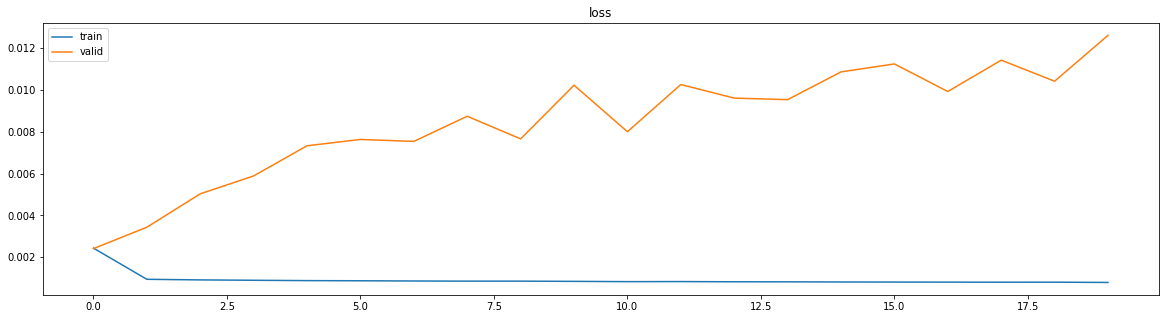

187.6579396724701


In [98]:
s = time.time()
net = train(net,train_iter,loss_function,optimizer,num_epochs=20)
print(time.time()-s)

In [99]:
# load best net
net = joblib.load('./model/net.pkl')
net.eval()

Net(
  (fc): Sequential(
    (0): Linear(in_features=546, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# make prediction(train)

In [100]:
from sklearn.metrics import r2_score,mean_absolute_error
t = pd.DataFrame(index=idx_lst[:sp1])
t['y_real'] = mm_y.inverse_transform(Y_train.detach().cpu().numpy().reshape(-1,1)).ravel()
t['y_pred'] = mm_y.inverse_transform(net(X_train).detach().cpu().numpy().reshape(-1,1)).ravel()
print(r2_score(t['y_real'],t['y_pred']))
t.head()

0.8601454545044211


,y_real,y_pred
2016-06-01 02:40:00,6467.759752,6346.355437
2016-06-01 02:50:00,6450.874168,6315.542286
2016-06-01 03:00:00,6443.690012,6324.128645
2016-06-01 03:10:00,6430.383177,6344.821084
2016-06-01 03:20:00,6446.393842,6330.990027


In [101]:
#fig = go.Figure()

#fig.add_trace(go.Scatter(x=t.index, y=t['y_real'], name='y_real'))
#fig.add_trace(go.Scatter(x=t.index, y=t['y_pred'], name='y_pred'))

#fig.update_layout(title_text='Time Series with Rangeslider',xaxis_rangeslider_visible=True)
#fig.show()

# make prediction(valid)

In [102]:
t = pd.DataFrame(index=idx_lst[sp1:sp2])
t['y_real'] = mm_y.inverse_transform(Y_valid.detach().cpu().numpy().reshape(-1,1)).ravel()
t['y_pred'] = mm_y.inverse_transform(net(X_valid).detach().cpu().numpy().reshape(-1,1)).ravel()
print(r2_score(t['y_real'],t['y_pred']))
t.head()

0.8525924090710967


,y_real,y_pred
2018-07-30 13:50:00,7170.437518,7208.471105
2018-07-30 14:00:00,7177.415309,7255.136161
2018-07-30 14:10:00,7186.383204,7192.991766
2018-07-30 14:20:00,7188.492340,7228.468510
2018-07-30 14:30:00,7160.727089,7217.659809


In [103]:
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=t.index, y=t['y_real'], name='y_real'))
#fig.add_trace(go.Scatter(x=t.index, y=t['y_pred'], name='y_pred'))
#fig.update_layout(title_text='Time Series with Rangeslider',xaxis_rangeslider_visible=True)
#fig.show()

# make prediction(test)

In [104]:
t = pd.DataFrame(index=idx_lst[sp2:])
t['y_real'] = mm_y.inverse_transform(Y_test.detach().cpu().numpy().reshape(-1,1)).ravel()
t['y_pred'] = mm_y.inverse_transform(net(X_test).detach().cpu().numpy().reshape(-1,1)).ravel()
print(r2_score(t['y_real'],t['y_pred']))
t.head()

0.7368457755125113


,y_real,y_pred
2019-03-31 04:50:00,7311.660195,7258.742235
2019-03-31 05:00:00,7314.208846,7226.933832
2019-03-31 05:10:00,7291.835977,7243.431982
2019-03-31 05:20:00,7272.463606,7254.666196
2019-03-31 05:30:00,7290.419103,7209.964731


In [105]:
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=t.index, y=t['y_real'], name='y_real'))
#fig.add_trace(go.Scatter(x=t.index, y=t['y_pred'], name='y_pred'))
#fig.update_layout(title_text='Time Series with Rangeslider',xaxis_rangeslider_visible=True)
#fig.show()